In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
from scipy.stats import linregress

home_dir = '/glade/work/devond/'

import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
def get_timeseries(data, mask, season = None):
    data_ts = data * cesm_area*mask
    if season is not None:
        data_ts = data_ts.sel(time=data_ts['time.season']==season)
        if season == 'DJF':
            data_ts = fix_time(data_ts)
    data_ts = (data_ts * data_ts.time.dt.days_in_month*3600*24).groupby(data_ts.time.dt.year).sum() #kg/s to kg/year
    data_ts = data_ts.sum(dim = ['lat','lon'])/(10**12) #kg to Gt
    
    return data_ts

In [3]:
### ----- Read ICE SHEET MASK data ----- ###

cesm_mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(cesm_mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
cesm_area = cesm_masks.area.values #grid cell areas
cesm_ism = cesm_masks.full_ism.values
cesm_gism = cesm_masks.grounded_ism.values

cesm_iceshelves = xr.open_dataset('/glade/work/devond/AIS_masks/iceshelfmask_CESM2.nc')
cesm_iceshelves = cesm_iceshelves.sel(latitude = slice(-90,-60))
cesm_shelves = cesm_iceshelves.ism.values
cesm_shelves[cesm_shelves==0]=np.nan

cesm_topo = xr.open_dataset('/glade/work/devond/AIS_masks/TOPO_CESM.nc')
cesm_topo =cesm_topo.sel(lat = slice(-90,-60))
cesm_topo['lat'] = cesm_masks.lat
cesm_topo = cesm_topo*cesm_gism
cesm_1500 = cesm_masks.where(cesm_topo.TOPO<1500).grounded_ism.values
cesm_3000 = cesm_masks.where((cesm_topo.TOPO<3000)&(cesm_topo.TOPO>=1500)).grounded_ism.values
cesm_4500 = cesm_masks.where((cesm_topo.TOPO>=3000)).grounded_ism.values

In [4]:
## SSP1
ssp1_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP1-2.6_2.nc')
ssp1_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP1-2.6_2.nc')
ssp1_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP1-2.6_2.nc')
ssp1_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP1-2.6_2.nc')
ssp1_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP1-2.6.nc').mean(dim = 'ensemble')['TREFHT']-273.15

ssp1_smb = (ssp1_snow.SNOW + ssp1_rain.RAIN - ssp1_evap.QSOIL - ssp1_runoff.QRUNOFF).mean(dim = 'ensemble') 


#grounded
ssp1_smb_g = get_timeseries(ssp1_smb, cesm_gism)
ssp1_temp_g = (ssp1_temp * cesm_gism).groupby(ssp1_temp.time.dt.year).mean()
ssp1_temp_g = (ssp1_temp_g*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)
# #grounded below 1500
# ssp1_smb_1500 = get_timeseries(ssp1_smb, cesm_1500)
# ssp1_temp_1500 = (ssp1_temp * cesm_1500).groupby(ssp1_temp.time.dt.year).mean()
# ssp1_temp_1500 = (ssp1_temp_1500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_1500)
# #grounded between 1500 and 3000
# ssp1_smb_3000 = get_timeseries(ssp1_smb, cesm_3000)
# ssp1_temp_3000 = (ssp1_temp * cesm_3000).groupby(ssp1_temp.time.dt.year).mean()
# ssp1_temp_3000 = (ssp1_temp_3000*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_3000)
# #grounded above 3000
# ssp1_smb_4500 = get_timeseries(ssp1_smb, cesm_4500)
# ssp1_temp_4500 = (ssp1_temp * cesm_4500).groupby(ssp1_temp.time.dt.year).mean()
# ssp1_temp_4500 = (ssp1_temp_4500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_4500)
#ice shelves
ssp1_smb_is = get_timeseries(ssp1_smb, cesm_shelves)
ssp1_temp_is = (ssp1_temp * cesm_shelves).groupby(ssp1_temp.time.dt.year).mean()
ssp1_temp_is = (ssp1_temp_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
## SSP3
ssp3_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP3-7.0_2.nc')
ssp3_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP3-7.0_2.nc')
ssp3_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP3-7.0_2.nc')
ssp3_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP3-7.0_2.nc')
ssp3_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP3-7.0.nc').mean(dim = 'ensemble')['TREFHT']-273.15

ssp3_smb = (ssp3_snow.SNOW + ssp3_rain.RAIN - ssp3_evap.QSOIL - ssp3_runoff.QRUNOFF).mean(dim = 'ensemble')


#grounded
ssp3_smb_g = get_timeseries(ssp3_smb, cesm_gism)
ssp3_temp_g = (ssp3_temp * cesm_gism).groupby(ssp3_temp.time.dt.year).mean()
ssp3_temp_g = (ssp3_temp_g*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)
# #grounded below 1500
# ssp3_smb_1500 = get_timeseries(ssp3_smb, cesm_1500)
# ssp3_temp_1500 = (ssp3_temp * cesm_1500).groupby(ssp3_temp.time.dt.year).mean()
# ssp3_temp_1500 = (ssp3_temp_1500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_1500)
# #grounded between 1500 and 3000
# ssp3_smb_3000 = get_timeseries(ssp3_smb, cesm_3000)
# ssp3_temp_3000 = (ssp3_temp * cesm_3000).groupby(ssp3_temp.time.dt.year).mean()
# ssp3_temp_3000 = (ssp3_temp_3000*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_3000)
# #grounded above 3000
# ssp3_smb_4500 = get_timeseries(ssp3_smb, cesm_4500)
# ssp3_temp_4500 = (ssp3_temp * cesm_4500).groupby(ssp3_temp.time.dt.year).mean()
# ssp3_temp_4500 = (ssp3_temp_4500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_4500)
#ice shelves
ssp3_smb_is = get_timeseries(ssp3_smb, cesm_shelves)
ssp3_temp_is = (ssp3_temp * cesm_shelves).groupby(ssp3_temp.time.dt.year).mean()
ssp3_temp_is = (ssp3_temp_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
## SSP5
ssp5_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP5-8.5_2.nc')
ssp5_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP5-8.5_2.nc')
ssp5_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP5-8.5_2.nc')
ssp5_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP5-8.5_2.nc')
ssp5_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP5-8.5.nc').mean(dim = 'ensemble')['TREFHT']-273.15

ssp5_smb = (ssp5_snow.SNOW + ssp5_rain.RAIN - ssp5_evap.QSOIL - ssp5_runoff.QRUNOFF).mean(dim = 'ensemble')

#grounded
ssp5_smb_g = get_timeseries(ssp5_smb, cesm_gism)
ssp5_temp_g = (ssp5_temp * cesm_gism).groupby(ssp5_temp.time.dt.year).mean()
ssp5_temp_g = (ssp5_temp_g*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)
# #grounded below 1500
# ssp5_smb_1500 = get_timeseries(ssp5_smb, cesm_1500)
# ssp5_temp_1500 = (ssp5_temp * cesm_1500).groupby(ssp5_temp.time.dt.year).mean()
# ssp5_temp_1500 = (ssp5_temp_1500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_1500)
# #grounded between 1500 and 3000
# ssp5_smb_3000 = get_timeseries(ssp5_smb, cesm_3000)
# ssp5_temp_3000 = (ssp5_temp * cesm_3000).groupby(ssp5_temp.time.dt.year).mean()
# ssp5_temp_3000 = (ssp5_temp_3000*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_3000)
# #grounded above 3000
# ssp5_smb_4500 = get_timeseries(ssp5_smb, cesm_4500)
# ssp5_temp_4500 = (ssp5_temp * cesm_4500).groupby(ssp1_temp.time.dt.year).mean()
# ssp5_temp_4500 = (ssp5_temp_4500*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_4500)
#ice shelves
ssp5_smb_is = get_timeseries(ssp5_smb, cesm_shelves)
ssp5_temp_is = (ssp5_temp * cesm_shelves).groupby(ssp5_temp.time.dt.year).mean()
ssp5_temp_is = (ssp5_temp_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
def plot_standardized_values(data1, data2, ax, c):
    ax.plot((data1-data1.mean())/data1.std(),(data2-data2.mean())/data2.std(), '.', color = c,markersize = 10)


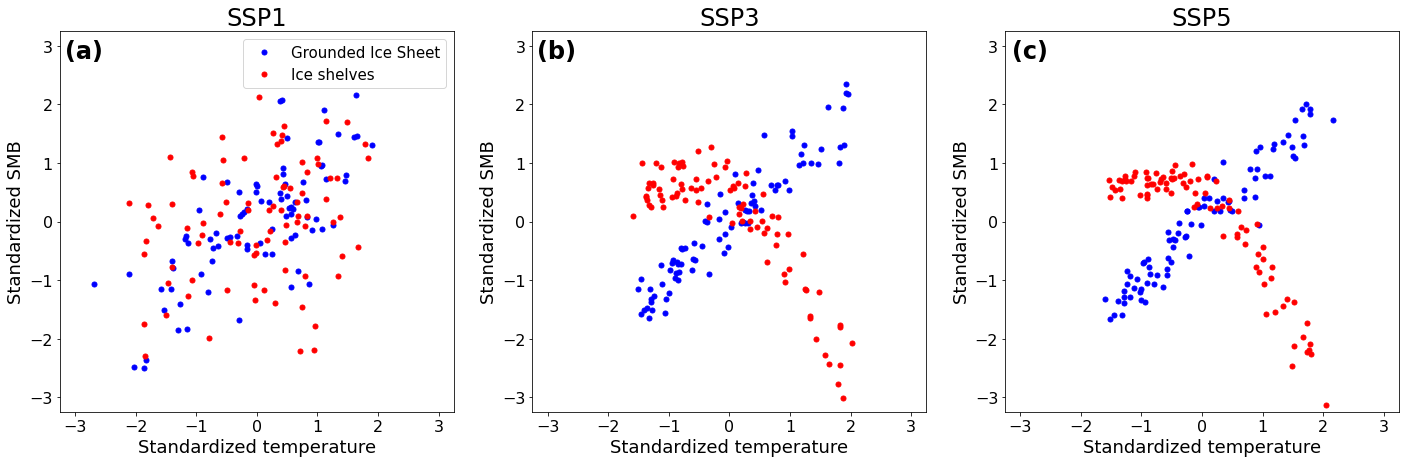

In [17]:
fig, ax = plt.subplots(1,3,figsize = (24,7))
plot_standardized_values(ssp1_temp_g,ssp1_smb_g, ax[0], 'blue')
plot_standardized_values(ssp1_temp_is,ssp1_smb_is, ax[0], 'red')
ax[0].set_xlabel('Standardized temperature', fontsize = 18)
ax[0].set_ylabel('Standardized SMB', fontsize = 18)
ax[0].set_title('SSP1', fontsize = 24)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Grounded Ice Sheet','Ice shelves'],prop={'size': 15})
ax[0].set_xlim([-3.25,3.25])
ax[0].set_ylim([-3.25,3.25])
ax[0].text(0.11, 0.98, '(a)', transform=ax[0].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

plot_standardized_values(ssp3_temp_g,ssp3_smb_g, ax[1], 'blue')
plot_standardized_values(ssp3_temp_is,ssp3_smb_is, ax[1], 'red')
ax[1].set_xlabel('Standardized temperature', fontsize = 18)
ax[1].set_ylabel('Standardized SMB', fontsize = 18)
ax[1].set_title('SSP3', fontsize = 24)
ax[1].tick_params(labelsize=16)
ax[1].set_xlim([-3.25,3.25])
ax[1].set_ylim([-3.25,3.25])
ax[1].text(0.11, 0.98, '(b)', transform=ax[1].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

plot_standardized_values(ssp5_temp_g,ssp5_smb_g, ax[2], 'blue')
plot_standardized_values(ssp5_temp_is,ssp5_smb_is, ax[2], 'red')
ax[2].set_xlabel('Standardized temperature', fontsize = 18)
ax[2].set_ylabel('Standardized SMB', fontsize = 18)
ax[2].set_title('SSP5', fontsize = 24)
ax[2].tick_params(labelsize=16)
ax[2].set_xlim([-3.25,3.25])
ax[2].set_ylim([-3.25,3.25])
ax[2].text(0.11, 0.98, '(c)', transform=ax[2].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

plt.savefig('future_temp_vs_smb.png', dpi = 300, bbox_inches = 'tight')